In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
data_path = "dataset/data_clean.csv"

df_clean = pd.read_csv(data_path)

df_clean.head()

,SeniorCitizen,MonthlyCharges,TotalCharges_log,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_cohort_12-24 Months,tenure_cohort_24-48 Months,tenure_cohort_Over 48 Months,Churn
0,0,29.85,3.429137,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,56.95,7.544597,1,0,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0
2,0,53.85,4.692723,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,0,42.30,7.518471,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,70.70,5.028148,0,0,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1


In [3]:
pos, neg = np.bincount(df_clean["Churn"])
total = pos + neg

print(f'Examples:\n  Total: {total}\n  Positive: {pos} ({100 * pos / total}%)\n  Negative: {neg} ({100 * neg / total}%)')

Examples:
  Total: 7032
  Positive: 5163 (73.42150170648465%)
  Negative: 1869 (26.57849829351536%)


In [4]:
df_train, df_test = train_test_split(df_clean, test_size=0.1)

df_train, df_val = train_test_split(df_train, test_size=0.1)

train_labels = np.array(df_train.pop("Churn"))
bool_train_labels = train_labels != 0
val_labels = np.array(df_val.pop("Churn"))
test_labels = np.array(df_test.pop("Churn"))

train_feat = np.array(df_train)
val_feat = np.array(df_val)
test_feat = np.array(df_test)

train_feat.shape, val_feat.shape, test_feat.shape

((5695, 32), (633, 32), (704, 32))

In [5]:
scaler = StandardScaler()

train_feat = np.clip(scaler.fit_transform(train_feat), -5, 5)
val_feat = np.clip(scaler.transform(val_feat), -5, 5)
test_feat = np.clip(scaler.transform(test_feat), -5, 5)

In [6]:
# pca = PCA(0.95)

In [7]:
xgb = XGBClassifier()

xgb.fit(train_feat, train_labels)

xgb.score(val_feat, val_labels)

0.8009478672985783

In [8]:
xgb_preds = xgb.predict(val_feat)

In [9]:
roc_auc_score(val_labels, xgb_preds)

0.7068620919387076

In [10]:
print(classification_report(val_labels, xgb_preds))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       475
           1       0.62      0.52      0.57       158

    accuracy                           0.80       633
   macro avg       0.73      0.71      0.72       633
weighted avg       0.79      0.80      0.79       633



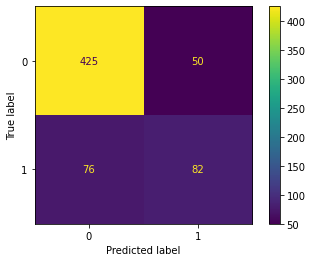

In [11]:
ConfusionMatrixDisplay.from_estimator(xgb, val_feat, val_labels)

In [12]:
search = {
    "xgboost": {
        "model": XGBClassifier(gpu_id=0, use_label_encoder=False, verbosity=1),
        "params": {
            "n_estimators": [10, 15, 25, 50, 75, 100, 150, 200],
            "learning_rate": [0.05, 0.1, 0.3, 0.5],
            "max_depth": [2, 3, 4, 5, 6, 7, 8]
        }
    }
}

In [14]:
scores = []

for name, clf in search.items():
    grid = GridSearchCV(
        estimator=clf["model"],
        param_grid=clf["params"],
        cv=3,
        return_train_score=False,
        n_jobs=-1,
        refit=False,
        verbose=3
    )
    grid.fit(train_feat, train_labels)
    scores.append({
        "name": name,
        "best_params": grid.best_params_,
        "best_score": grid.best_score_
    })

Fitting 3 folds for each of 224 candidates, totalling 672 fits


In [15]:
scores

[{'name': 'xgboost',
  'best_params': {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 15},
  'best_score': 0.7987702843250464}]

In [16]:
best_xgb = XGBClassifier(n_estimators=15, learning_rate=0.3, max_depth=5)

best_xgb.fit(train_feat, train_labels)

best_xgb.score(val_feat, val_labels)

0.8230647709320695

In [17]:
preds = best_xgb.predict(val_feat)

In [18]:
roc_auc_score(val_labels, preds)

0.7321585609593604

In [19]:
print(classification_report(val_labels, preds))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       475
           1       0.68      0.55      0.61       158

    accuracy                           0.82       633
   macro avg       0.77      0.73      0.75       633
weighted avg       0.81      0.82      0.82       633



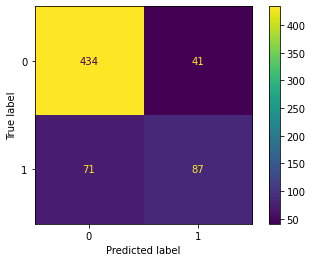

In [20]:
ConfusionMatrixDisplay.from_estimator(best_xgb, val_feat, val_labels)

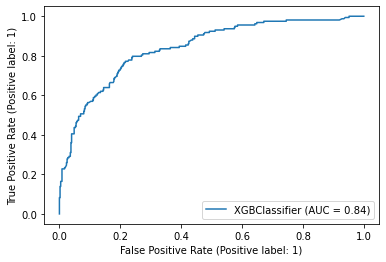

In [21]:
RocCurveDisplay.from_estimator(best_xgb, val_feat, val_labels)

### Test set score

In [22]:
best_xgb.score(test_feat, test_labels)

0.8252840909090909

In [23]:
test_preds = best_xgb.predict(test_feat)

In [24]:
roc_auc_score(test_labels, test_preds)

0.7300611864857675

In [25]:
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89       525
           1       0.71      0.54      0.61       179

    accuracy                           0.83       704
   macro avg       0.78      0.73      0.75       704
weighted avg       0.82      0.83      0.82       704



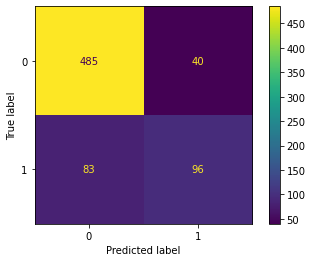

In [26]:
ConfusionMatrixDisplay.from_estimator(best_xgb, test_feat, test_labels)

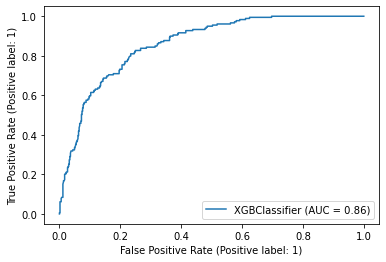

In [27]:
RocCurveDisplay.from_estimator(best_xgb, test_feat, test_labels)